In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

Load system model from Excel

In [2]:
model = pd.read_excel('Example11_9_Network_Model_24hour.xlsx', sheet_name=None)
gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
gen.index+=pd.TimedeltaIndex(gen.HE-1, unit='h')
gen = gen.drop(columns='HE')
installed = np.array(model['Gen']['Installed MW'])
gen = gen[model['Gen']['Type']].apply(np.array, axis='columns')
gen = gen.apply(lambda x: x*installed)
gen.name = 'Maximum Generation'

In [3]:
demand = model['LoadProfiles'].set_index('Date')
demand.index+=pd.TimedeltaIndex(demand.HE-1, unit='h')
demand = demand.drop(columns='HE')
load = demand.loc[:,demand.columns.str.contains('Load')].apply(np.array, axis='columns')
load.name = 'Fixed Load'
price = demand.loc[:,demand.columns.str.contains('Price')].apply(np.array, axis='columns')
price.name = 'Fixed Price'

In [4]:
input = pd.DataFrame(gen).join([load, price], how='inner')

In [5]:
x = input.iloc[0].copy()

Problem parameters, modeled after the network in Example 11_9 in PowerWorld Simulator 18 (Glover, Sarma & Overbye Edition) [Fourth Edition Sample Cases](https://www.powerworld.com/simulator-18-glover-sarma-overbye-edition-download)

In [6]:
# Read Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# System base, in MVA
base = 100

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# The buses with generators and loads
L = np.array(model['Load']['Number of Bus']-1)
G = np.array(model['Gen']['Number of Bus']-1)

# Transformation matrices. These define the change-of-variables from the generator/load spaces to the bus space.
AG = np.zeros((N,len(G)))
AG[G,:] = np.eye(len(G))
AL = np.zeros((N,len(L)))
AL[L,:] = np.eye(len(L))

# Elasticity
e = -0.5

We solve a **demand-side** problem with zero marginal cost, fixed supply, and elastic demand. For this minimal example, we make the follwing assumptions:
- Each load submits a demand curve. The system operator dispatches to maximize total utlity $U(P)$.
- For each load, elasticity is constant. That is, the marginal utility for load $i$ is given by $\frac{dU_i}{dP_i}=K_iP_i^{\frac{1}{e_i}}$, where $e_i<0$ is the elasticity. Note that this formulation insures that marginal benefit is always positive.
- There is no upper limit on consumption.

This function accepts:
- An elasticity $e$ (constant across loads for now)
- A nominal operating point for load $(\hat{P}_d,\lambda)$ such that $\nabla_{P_d}U(\hat{P}_d)=\mathbf{1}\lambda$
- A vector of nominal generator outputs $P_g$
- A scaling factor for generator outputs

It returns a pandas series fully specifying the simulation.

In [7]:
def sim(row):

    row = row.copy()

    p_g_max = row['Maximum Generation']/base
    price = row['Fixed Price']
    p_d_0 = row['Fixed Load']/base
    
    K = price/(p_d_0)**(1/e)

    p_d = cp.Variable(len(L))
    p_g = cp.Variable(len(G))
    delta = cp.Variable(N)
    constraints = [
        AG@p_g-AL@p_d == -B@delta,
        cp.multiply(B, delta[:,np.newaxis]-delta[np.newaxis,:]) <= P_line,
        p_g <= p_g_max,
        p_g >= 0
    ]
    U = cp.Problem(
        cp.Maximize(e/(1+e)*cp.sum(cp.multiply(K,(p_d)**(1/e+1)))),
        constraints
    ).solve()

    row['Dispatched Generation'] = p_g.value*base
    row['Dispatched Load'] = p_d.value*base
    row['LMP'] = -constraints[0].dual_value
    row['congestion'] = constraints[1].dual_value
    row['U'] = U

    return row

Let's do a sweep across generator factors for a couple different elasticities. We'll choose $\hat{P}_d$, $\lambda$, and $P_g$ using the parameters and solution to the supply-side problem.

In [8]:
results = input.apply(sim, axis='columns')

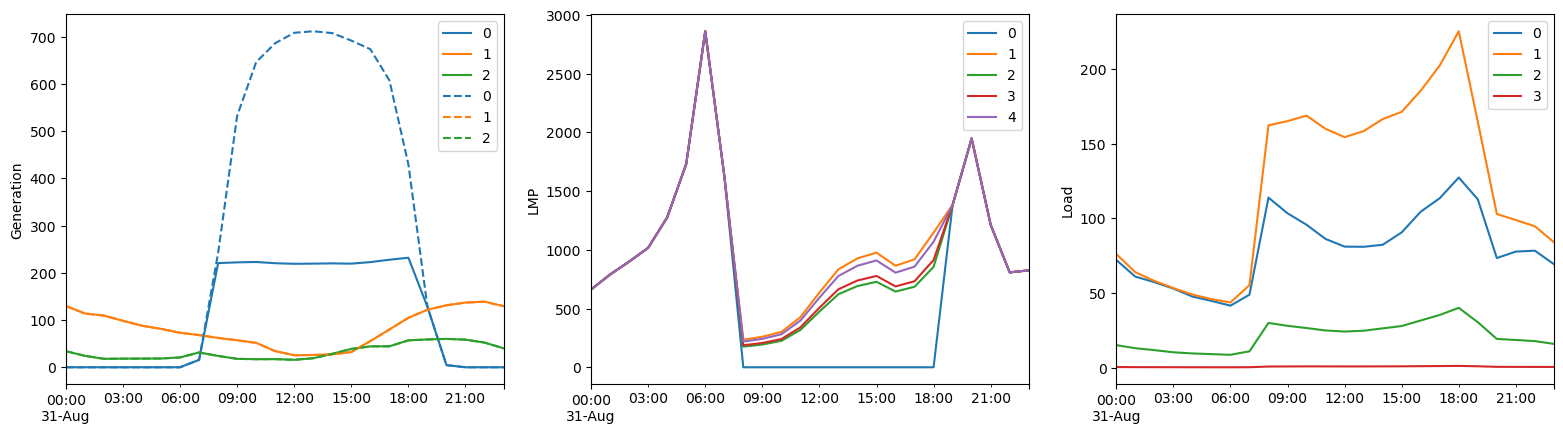

In [10]:
fig, ax = plt.subplots(1,3)

results['Dispatched Generation'].apply(pd.Series).plot(ax=ax[0])
colors = [line.get_color() for line in ax[0].lines]
results['Maximum Generation'].apply(pd.Series).plot(ax=ax[0], linestyle='dashed', color=colors)
ax[0].set_ylabel('Generation')

results['LMP'].apply(pd.Series).plot(ax=ax[1])
ax[1].set_ylabel('LMP')

results['Dispatched Load'].apply(pd.Series).plot(ax=ax[2])
ax[2].set_ylabel('Load')

fig.set_size_inches(fig.get_size_inches()*[3,1])
fig.show()